In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras

2024-03-08 22:30:22.215118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 22:30:22.215226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 22:30:22.354900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


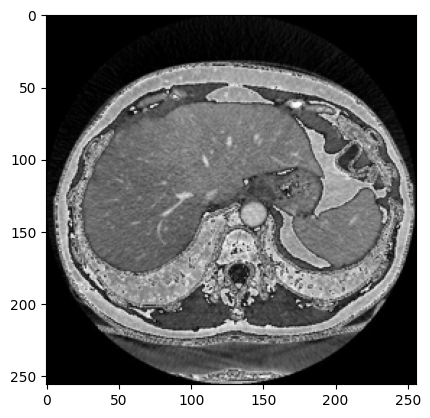

In [2]:
img_path='/kaggle/input/segmentation-of-liver/images/images/10.jpg'
img_pillow=Image.open(img_path)
img_color=img_pillow.convert('RGB')
img_resize=img_color.resize((256,256))
img_arr=np.array(img_resize)
plt.imshow(img_arr)

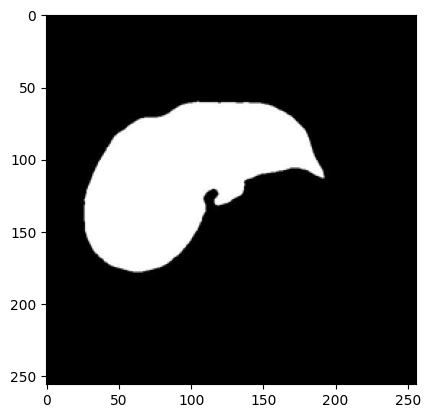

In [3]:
img_mask='/kaggle/input/segmentation-of-liver/liver_masks/liver_masks/10.jpg'
img_pillow=Image.open(img_mask)
img_color=img_pillow.convert('RGB')
img_resize=img_color.resize((256,256))
img_arr=np.array(img_resize)
plt.imshow(img_arr)

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tqdm import tqdm

In [5]:
im_width = 256
im_height = 256
ids1 = next(os.walk("/kaggle/input/segmentation-of-liver/images/images/"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids1), total=len(ids1)):
    # Load images
    img = load_img("/kaggle/input/segmentation-of-liver/images/images/" + id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256,256, 1), mode='constant', preserve_range=True)
    # Load masks
    mask = img_to_array(load_img("/kaggle/input/segmentation-of-liver/liver_masks/liver_masks/" + id_, color_mode='grayscale'))
    mask = resize(mask, (256,256, 1), mode='constant', preserve_range=True)
    # Save images
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

100%|██████████| 2823/2823 [01:36<00:00, 29.25it/s]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

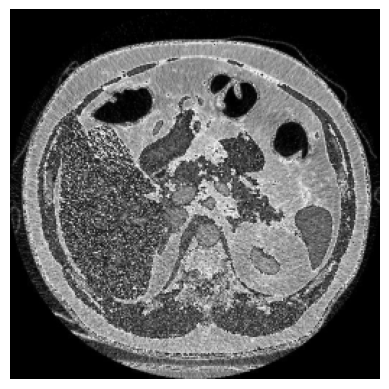

In [7]:
import matplotlib.pyplot as plt

# Assuming x_train has shape (batch_size, height, width, channels)
# Select the index of the image you want to plot
image_index = 0  # Change this to the index of the image you want to plot

# Extract the image
img = X_train[image_index]

# Plot the image
plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

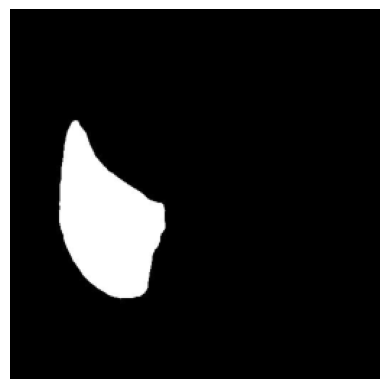

In [8]:
import matplotlib.pyplot as plt

# Assuming x_train has shape (batch_size, height, width, channels)
# Select the index of the image you want to plot
image_index = 0  # Change this to the index of the image you want to plot

# Extract the image
img = y_train[image_index]

# Plot the image
plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

In [9]:
X_train.shape

(2258, 256, 256, 1)

In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [11]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,1))
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [12]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=4, epochs=3)

Epoch 1/3


I0000 00:00:1709937215.302440     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


565/565 ━━━━━━━━━━━━━━━━━━━━ 248s 304ms/step - accuracy: 0.9287 - loss: 0.1596
Epoch 2/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 136s 241ms/step - accuracy: 0.9572 - loss: 0.0629
Epoch 3/3
565/565 ━━━━━━━━━━━━━━━━━━━━ 138s 244ms/step - accuracy: 0.9587 - loss: 0.0532


In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)

2024-03-08 22:42:28.582907: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-08 22:42:28.638951: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.056183754s
Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9592 - loss: 0.0462
Test Accuracy: 0.9607369899749756
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 671ms/step


In [15]:
model.save('/kaggle/working/Liver_Model.hdf5')

Image shape: (1, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


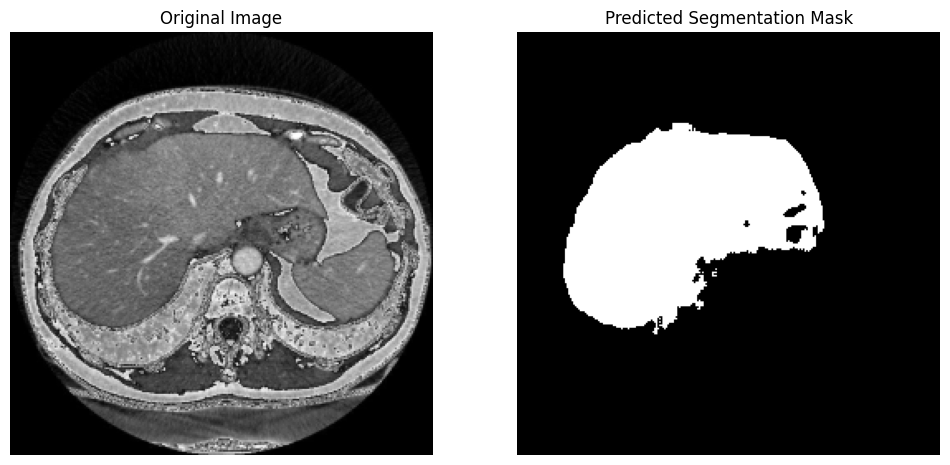

In [14]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

im_width = 256
im_height = 256

img_path = "/kaggle/input/segmentation-of-liver/images/images/10.jpg"

img = load_img(img_path, color_mode='grayscale')
x_img = img_to_array(img)
x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
x_img = x_img / 255.0


# Expand dimensions to match model input shape
x_img = np.expand_dims(x_img, axis=0)

# Ensure the data types are float32
x_img = x_img.astype(np.float32)
# Print the shape of the loaded image and mask
print("Image shape:", x_img.shape)


# Perform prediction
predictions = model.predict(x_img)

# Since your model outputs the segmentation mask, you might want to threshold the predictions to obtain a binary mask
threshold = 0.5  # You can adjust this threshold if needed
binary_predictions = (predictions > threshold).astype(np.float32)

# Plot the original image and the predicted segmentation mask
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(x_img.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(binary_predictions.squeeze(), cmap='gray')
plt.title('Predicted Segmentation Mask')
plt.axis('off')

plt.show()